In [1]:
import sys
sys.path.append("../../")

In [2]:
!pip install aif360

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.compose import make_column_transformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder

from aif360.sklearn.datasets import fetch_adult
from aif360.sklearn.metrics import disparate_impact_ratio, average_odds_error, generalized_fpr, statistical_parity_difference, equal_opportunity_difference
from aif360.sklearn.metrics import generalized_fnr, difference

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.utils.data as data_utils

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from IPython import display
import os
from torch.utils.data.dataset import Dataset

In [6]:
from uq360.algorithms.variational_bayesian_neural_networks.bnn import BnnClassification
from uq360.metrics.classification_metrics import entropy_based_uncertainty_decomposition, plot_risk_vs_rejection_rate

In [7]:
X, y, sample_weight = fetch_adult()
X.head()

,,,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
,race,sex,,,,,,,,,,,,,
0,Non-white,Male,25.0,Private,11th,7.0,Never-married,Machine-op-inspct,Own-child,Non-white,Male,0.0,0.0,40.0,United-States
1,White,Male,38.0,Private,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States
2,White,Male,28.0,Local-gov,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States
3,Non-white,Male,44.0,Private,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Non-white,Male,7688.0,0.0,40.0,United-States
5,White,Male,34.0,Private,10th,6.0,Never-married,Other-service,Not-in-family,White,Male,0.0,0.0,30.0,United-States


In [8]:
X.index = pd.MultiIndex.from_arrays(X.index.codes, names=X.index.names)
y.index = pd.MultiIndex.from_arrays(y.index.codes, names=y.index.names)

In [9]:
y = pd.Series(y.factorize(sort=True)[0], index=y.index)

In [10]:
(X_train, X_test,
 y_train, y_test) = train_test_split(X, y, train_size=0.7, random_state=1234567)
(X_train, X_calib,
 y_train, y_calib) = train_test_split(X_train, y_train, train_size=0.7, random_state=1234567)

In [11]:
y_train

       race  sex
32587  0     0      1
8287   1     0      0
35740  1     1      1
31610  1     0      0
8317   1     1      1
                   ..
3582   1     1      0
26929  1     1      0
33290  1     1      0
4366   1     0      0
11868  1     1      1
Length: 22158, dtype: int64

In [12]:
X_train["sex"]=="Male"

       race  sex
32587  0     0      False
8287   1     0      False
35740  1     1       True
31610  1     0      False
8317   1     1       True
                    ...  
3582   1     1       True
26929  1     1       True
33290  1     1       True
4366   1     0      False
11868  1     1       True
Name: sex, Length: 22158, dtype: bool

In [13]:
#X_train = X_train[X_train["sex"]=="Male"]
#y_train = y_train[y_train.sex==1]

In [14]:
ohe = make_column_transformer(
        (OneHotEncoder(sparse=False, handle_unknown = 'ignore'), X_train.dtypes == 'category'),
        remainder='passthrough')
X_train  = pd.DataFrame(ohe.fit_transform(X_train), index=X_train.index)
X_test = pd.DataFrame(ohe.transform(X_test), index=X_test.index)
X_calib = pd.DataFrame(ohe.transform(X_calib), index=X_calib.index)

X_train.head()

,,,0,1,2,3,4,5,6,7,8,9,...,89,90,91,92,93,94,95,96,97,98
,race,sex,,,,,,,,,,,,,,,,,,,,,
32587,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,27.0,9.0,0.0,1887.0,40.0
8287,1,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,54.0,9.0,0.0,0.0,80.0
35740,1,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,55.0,9.0,0.0,1887.0,40.0
31610,1,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,18.0,9.0,0.0,0.0,30.0
8317,1,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,38.0,9.0,0.0,0.0,41.0


In [15]:
X.workclass.cat.remove_unused_categories(inplace=True)
pd.get_dummies(X).head()

,,,age,education-num,capital-gain,capital-loss,hours-per-week,workclass_Federal-gov,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
,race,sex,,,,,,,,,,,,,,,,,,,,,
0,0,1,25.0,7.0,0.0,0.0,40.0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
1,1,1,38.0,9.0,0.0,0.0,50.0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,1,1,28.0,12.0,0.0,0.0,40.0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,1,44.0,10.0,7688.0,0.0,40.0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
5,1,1,34.0,6.0,0.0,0.0,30.0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0


In [16]:
X_train.head()

,,,0,1,2,3,4,5,6,7,8,9,...,89,90,91,92,93,94,95,96,97,98
,race,sex,,,,,,,,,,,,,,,,,,,,,
32587,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,27.0,9.0,0.0,1887.0,40.0
8287,1,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,54.0,9.0,0.0,0.0,80.0
35740,1,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,55.0,9.0,0.0,1887.0,40.0
31610,1,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,18.0,9.0,0.0,0.0,30.0
8317,1,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,38.0,9.0,0.0,0.0,41.0


In [17]:
# Standardize the features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

norm_X_train = scaler.transform(X_train)
norm_X_test = scaler.transform(X_test)
norm_X_calib = scaler.transform(X_calib)

In [18]:
#train = data_utils.TensorDataset(torch.Tensor(norm_X_train), torch.Tensor(y_train.values).long())
#train_loader = data_utils.DataLoader(train, batch_size=50, shuffle=True)

In [19]:
test = data_utils.TensorDataset(torch.Tensor(norm_X_test), torch.Tensor(y_test.values).long())
test_loader = data_utils.DataLoader(test, batch_size=50, shuffle=False)

In [20]:
config = {"ip_dim": X_train.values.shape[1], "op_dim": 2, "num_nodes": 128, "num_layers": 1,
          "num_epochs": 10, "step_size": 0.001}
config['hshoe_scale'] = 1e-1
config['use_reg_hshoe']=True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [21]:
bnn = BnnClassification(config=config, device=device, prior="RegHshoe")

#bnn = bnn.fit(train_loader=train_loader)
bnn = bnn.fit(X=norm_X_train, y=y_train.values)

Epoch[10/10], neg elbo: 1.621017


In [22]:
def get_test_results(test_loader, bnn):
    correct = 0
    total = 0

    all_mean = []
    all_var = []
    all_true_labels = []
    all_pred_labels = []

    all_total = []
    all_epistemic = []
    all_aleotoric = []

    for test_batch_x, test_batch_y in test_loader:

        with torch.no_grad():
            predicted, pred_mean, pred_var, y_prob_samples = bnn.predict(test_batch_x)
            pred_total_uq, pred_aleo, pred_epi = entropy_based_uncertainty_decomposition(y_prob_samples)

            all_mean.append(pred_mean)
            all_var.append(pred_var)
            all_true_labels.append(test_batch_y)
            all_pred_labels.append(predicted)

            all_total.append(pred_total_uq)
            all_epistemic.append(pred_epi)
            all_aleotoric.append(pred_aleo)

            total += test_batch_y.size(0)
            correct += (predicted == test_batch_y.numpy()).sum()
    print("accuracy: %d %%" % (100 * correct / total))
    
    all_mean_mat = np.concatenate(all_mean, axis=0)
    all_true_labels_mat = np.concatenate(all_true_labels, axis=0)
    all_pred_labels_mat = np.concatenate(all_pred_labels, axis=0)

    all_total_mat = np.concatenate(all_total, axis=0)
    all_epi_mat = np.concatenate(all_epistemic, axis=0)
    all_aleo_mat = np.concatenate(all_aleotoric, axis=0)

    return all_mean_mat, all_true_labels_mat, all_pred_labels_mat, all_total_mat, all_epi_mat, all_aleo_mat

In [23]:
all_mean_mat, all_true_labels_mat, all_pred_labels_mat, all_total_mat, all_epi_mat, all_aleo_mat = get_test_results(test_loader, bnn)

accuracy: 85 %


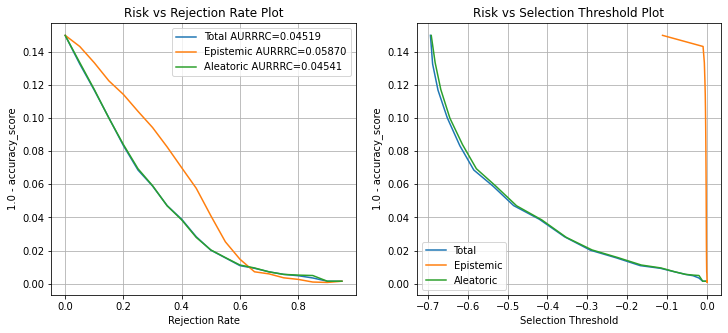

In [24]:
_ = plot_risk_vs_rejection_rate(
    y_true=[all_true_labels_mat, all_true_labels_mat, all_true_labels_mat],
    y_prob=[None, None, None],
    y_pred=[all_pred_labels_mat, all_pred_labels_mat, all_pred_labels_mat],
    selection_scores=[-all_total_mat, -all_epi_mat, -all_aleo_mat],
    plot_label=["Total", "Epistemic", "Aleatoric"],
    risk_func=accuracy_score,
    subgroup_ids=[None, None, None],
    num_bins=20
)

### Let us now to how to use `ClassificationCalibration` to calibrate the probability scores.

#### BNN scores are typically well calibrated. We will artificially make the scores overconfident to show the effect of post-hoc calibration. 

In [25]:
from uq360.algorithms.classification_calibration.classification_calibration import ClassificationCalibration
from uq360.metrics.classification_metrics import plot_reliability_diagram

In [26]:
from scipy.special import softmax

In [27]:
calib_from_features = ClassificationCalibration(
    num_classes=2,
    fit_mode="features",
    base_model_prediction_func=lambda x: softmax(10*bnn.predict(x).y_prob, axis=1)
)

In [28]:
calib_from_features = calib_from_features.fit(X=norm_X_calib, y=y_calib.values)

In [29]:
y_prob_calibrated_from_features = calib_from_features.predict(norm_X_test).y_prob

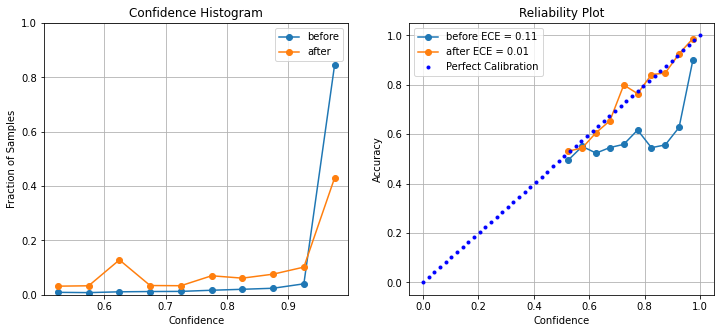

In [30]:
_ = plot_reliability_diagram([y_test, y_test],
                         [softmax(10*bnn.predict(norm_X_test).y_prob, axis=1), y_prob_calibrated_from_features],
                             [None, None],
                         plot_label = ["before", "after"],
                            num_bins=10)

### When base model precomputed probability scores are available or computing them again is expensive, `fit_mode` can be used.

In [31]:
y_prob_calib = bnn.predict(norm_X_calib).y_prob
y_prob_test = bnn.predict(norm_X_test).y_prob

In [32]:
calib_from_probs = ClassificationCalibration(num_classes=2, fit_mode="probs")

In [33]:
calib_from_probs = calib_from_probs.fit(X=softmax(10*y_prob_calib, axis=1), y=y_calib.values)

In [34]:
y_prob_calibrated_from_probs = calib_from_probs.predict(softmax(10*y_prob_test, axis=1)).y_prob

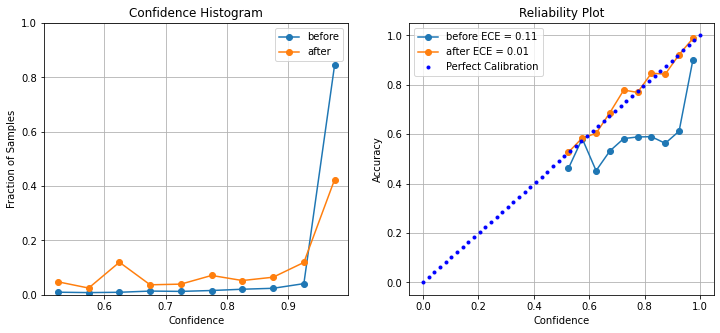

In [35]:
_ = plot_reliability_diagram([y_test, y_test],
                         [softmax(10*y_prob_test, axis=1), y_prob_calibrated_from_probs],
                             [None, None],
                         plot_label = ["before", "after"],
                            num_bins=10)